In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf

from sklearn.metrics import (
    classification_report, 
    matthews_corrcoef, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay
)

2024-07-16 10:09:33.049839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 10:09:33.049890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 10:09:33.115607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 10:09:33.161087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices('GPU')

2024-07-16 10:09:35.557537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 10:09:35.753127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 10:09:35.753204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
BATCH_SIZE = 256

## Load Dataset

In [4]:
df = pd.read_parquet("../dataset/combined_nn/test-all.parquet")
feature_names = df.columns.tolist()[:-1]

X_test = df.drop(columns=["target"]).values

In [5]:
df.head()

,sob_mean,sob_sum,o2_mean,o2_sum,uo_mean,uo_sum,chl_mean,chl_sum,dissic_mean,dissic_sum,...,spco2_sum,nppv_mean,nppv_sum,pbo_mean,pbo_sum,tob_mean,tob_sum,si_mean,si_sum,target
437397,34.704899,416.458771,223.508652,223.508652,0.096540,1.158477,0.204781,0.204781,2.066980,2.066980,...,34.868469,5.638765,5.638765,4679.432129,56153.187500,0.595773,7.149278,3.003322,3.003322,0
1781888,34.731422,416.777069,214.151016,214.151016,0.032286,0.387436,0.072492,0.072492,2.041442,2.041442,...,35.861469,1.545734,1.545734,3434.397705,41212.773438,1.191451,14.297417,3.088437,3.088437,0
1625505,34.718845,555.501526,233.777924,467.555847,0.039581,0.633293,0.364079,0.728159,2.084589,4.169178,...,66.043945,10.758173,21.516346,5103.108887,81649.742188,0.410561,6.568973,2.850184,5.700369,0
1886818,34.711090,416.533081,211.267059,211.267059,0.067452,0.809429,0.081660,0.081660,2.040434,2.040434,...,38.833748,1.921440,1.921440,4812.353516,57748.242188,0.638760,7.665117,3.248570,3.248570,0
269928,34.727493,312.547455,211.444901,211.444901,-0.271098,-2.439885,0.104395,0.104395,2.021160,2.021160,...,36.260555,2.959469,2.959469,4664.943848,41984.496094,0.778541,7.006873,3.234316,3.234316,0


## Load Model

In [6]:
model = tf.keras.models.load_model("../scripts/modelsr2/model-all_resnet_focal.keras")
# model.summary()

2024-07-16 08:53:27.768432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 08:53:27.768606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 08:53:27.768663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 08:53:27.956761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 08:53:27.957416: I external/local_xla/xla/stream_executor

In [162]:
y_test = df.iloc[:, -1].astype(int)

st = time.time()
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0).ravel()
dt = time.time() - st

print("Time:", np.round(dt, 4))
print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))
print("ROC-AUC:", np.round(roc_auc_score(y_test, y_pred), 4))
print("AP:", np.round(average_precision_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

9877/9877 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
Time: 23.0673
MCC: 0.9629
Accuracy: 0.9991
Precision: 0.9626
Recall: 0.9641
F1: 0.9634
ROC-AUC: 0.9818
AP: 0.9285
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    312227
           1       0.96      0.96      0.96      3817

    accuracy                           1.00    316044
   macro avg       0.98      0.98      0.98    316044
weighted avg       1.00      1.00      1.00    316044



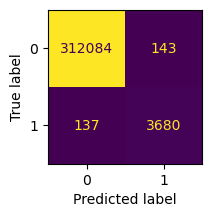

In [163]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)

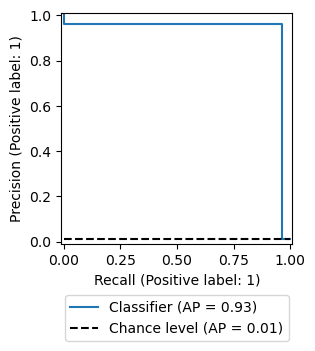

In [164]:
fig, ax = plt.subplots(figsize=(3, 3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax, plot_chance_level=True)
plt.legend(bbox_to_anchor=(0, -0.45, 1, 0.2), loc="lower center")

## Reclassify

In [7]:
gpd_africa = gpd.read_file("../dataset/africa/shp/grid-sea-africa-zoned.shp")
gpd_australia = gpd.read_file("../dataset/australia/shp/grid-sea-australia-zoned.shp")

In [8]:
df_africa = pd.read_parquet("../dataset/combined/zonal/africa.parquet")
df_australia = pd.read_parquet("../dataset/combined/zonal/australia.parquet")

In [9]:
df_africa[df_africa["ts"] >= "2023-01-01"]

,zone_id,ts,sob_mean,sob_sum,o2_mean,o2_sum,uo_mean,uo_sum,chl_mean,chl_sum,...,spco2_sum,nppv_mean,nppv_sum,pbo_mean,pbo_sum,tob_mean,tob_sum,si_mean,si_sum,target
1109397,126,2023-05-22,35.026119,105.078362,240.421371,240.421371,-0.198978,-0.596933,1.340599,1.340599,...,30.992777,37.936146,37.936146,45.163334,135.490005,12.226613,36.679840,2.372569,2.372569,0
1109398,135,2023-05-22,35.265999,35.265999,239.051392,478.102783,-0.315488,-0.315488,1.366075,2.732151,...,62.496307,35.016998,70.033997,35.651169,35.651169,16.405302,16.405302,2.424422,4.848845,1
1109399,169,2023-05-22,35.243912,105.731735,237.723083,237.723083,-0.122599,-0.367796,1.325541,1.325541,...,31.196625,42.888103,42.888103,32.090046,96.270142,15.963172,47.889515,2.484892,2.484892,0
1109400,178,2023-05-22,35.234768,70.469536,237.789124,237.789124,-0.167928,-0.335856,1.491704,1.491704,...,31.086004,45.629971,45.629971,29.342491,58.684982,15.350924,30.701847,2.499253,2.499253,1
1109401,188,2023-05-22,35.151783,210.910690,236.707260,236.707260,-0.155760,-0.934559,1.341901,1.341901,...,30.086210,42.495705,42.495705,27.001066,162.006393,15.107807,90.646843,2.479901,2.479901,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108584,8586,2023-11-30,34.748669,104.246002,233.905289,233.905289,0.047941,0.143824,0.053613,0.053613,...,37.851978,0.425017,0.425017,3068.090820,9204.272461,1.743774,5.231322,3.068152,3.068152,0
2108585,8587,2023-11-30,34.738064,138.952255,235.182053,235.182053,0.160349,0.641395,0.071966,0.071966,...,37.712643,0.667568,0.667568,3490.712891,13962.851562,1.258057,5.032228,3.013668,3.013668,0
2108586,8588,2023-11-30,34.734421,138.937683,236.739044,236.739044,0.198470,0.793880,0.090635,0.090635,...,37.471886,1.094450,1.094450,3669.006592,14676.026367,1.074405,4.297622,2.959563,2.959563,0
2108587,8589,2023-11-30,34.735794,104.207382,241.088593,482.177185,0.162734,0.488203,0.165637,0.331275,...,74.599289,5.721974,11.443949,3728.517578,11185.552734,1.095919,3.287757,2.798438,5.596876,0


In [13]:
viscols = feature_names + ["zone_id", "ts", "target"]
# df_visualize = pd.concat([
#     df_africa[df_africa["ts"].between("2023-06-01", "2023-06-30")][viscols].assign(country="africa"),
#     df_australia[df_australia["ts"].between("2023-06-01", "2023-06-30")][viscols].assign(country="australia"),
# ], ignore_index=True)

df_visualize = pd.concat([
    df_africa[df_africa["ts"] >= "2023-01-01"][viscols].assign(country="africa"),
    df_australia[df_australia["ts"] >= "2023-01-01"][viscols].assign(country="australia"),
], ignore_index=True)

df_visualize

,sob_mean,sob_sum,o2_mean,o2_sum,uo_mean,uo_sum,chl_mean,chl_sum,dissic_mean,dissic_sum,...,pbo_mean,pbo_sum,tob_mean,tob_sum,si_mean,si_sum,zone_id,ts,target,country
0,35.026119,105.078362,240.421371,240.421371,-0.198978,-0.596933,1.340599,1.340599,2.076316,2.076316,...,45.163334,135.490005,12.226613,36.679840,2.372569,2.372569,126,2023-05-22,0,africa
1,35.265999,35.265999,239.051392,478.102783,-0.315488,-0.315488,1.366075,2.732151,2.076982,4.153964,...,35.651169,35.651169,16.405302,16.405302,2.424422,4.848845,135,2023-05-22,1,africa
2,35.243912,105.731735,237.723083,237.723083,-0.122599,-0.367796,1.325541,1.325541,2.073903,2.073903,...,32.090046,96.270142,15.963172,47.889515,2.484892,2.484892,169,2023-05-22,0,africa
3,35.234768,70.469536,237.789124,237.789124,-0.167928,-0.335856,1.491704,1.491704,2.073568,2.073568,...,29.342491,58.684982,15.350924,30.701847,2.499253,2.499253,178,2023-05-22,1,africa
4,35.151783,210.910690,236.707260,236.707260,-0.155760,-0.934559,1.341901,1.341901,2.065862,2.065862,...,27.001066,162.006393,15.107807,90.646843,2.479901,2.479901,188,2023-05-22,1,africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497627,34.982315,279.858521,257.712860,257.712860,-0.150230,-1.201843,0.481599,0.481599,2.123778,2.123778,...,323.932892,2591.463135,10.551512,84.412094,1.244896,1.244896,4706,2023-11-30,0,australia
1497628,35.494236,319.448120,256.324524,256.324524,-0.216973,-1.952757,0.598058,0.598058,2.127377,2.127377,...,75.884018,682.956177,14.054930,126.494370,1.361494,1.361494,4713,2023-11-30,0,australia
1497629,35.405701,212.434204,256.571167,256.571167,-0.142423,-0.854539,0.462334,0.462334,2.124882,2.124882,...,84.599068,507.594421,13.548224,81.289345,1.243016,1.243016,4714,2023-11-30,0,australia
1497630,35.549076,284.392609,256.036896,256.036896,-0.180806,-1.446445,0.595183,0.595183,2.127872,2.127872,...,65.152466,521.219727,14.299137,114.393097,1.357483,1.357483,4720,2023-11-30,0,australia


In [170]:
X_vis = df_visualize[feature_names].values
y_vis = df_visualize["target"].values

st = time.time()
vis_proba = model.predict(X_vis)
# vis_proba[vis_proba == 0] = np.finfo(float).eps # change zero to epsilon
y_pred_vis = np.where(vis_proba > 0.5, 1, 0)
dt = time.time() - st

print("Time:", np.round(dt, 4))
print("MCC:", np.round(matthews_corrcoef(y_vis, y_pred_vis), 4))
print("Accuracy:", np.round(accuracy_score(y_vis, y_pred_vis), 4))
print("Precision:", np.round(precision_score(y_vis, y_pred_vis), 4))
print("Recall:", np.round(recall_score(y_vis, y_pred_vis), 4))
print("F1:", np.round(f1_score(y_vis, y_pred_vis), 4))
print("ROC-AUC:", np.round(roc_auc_score(y_vis, y_pred_vis), 4))
print("AP:", np.round(average_precision_score(y_vis, y_pred_vis), 4))

print(classification_report(y_vis, y_pred_vis))

46801/46801 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step
Time: 99.8168
MCC: 0.9731
Accuracy: 0.9994
Precision: 0.9745
Recall: 0.9725
F1: 0.9735
ROC-AUC: 0.9861
AP: 0.948
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1479544
           1       0.97      0.97      0.97     18088

    accuracy                           1.00   1497632
   macro avg       0.99      0.99      0.99   1497632
weighted avg       1.00      1.00      1.00   1497632



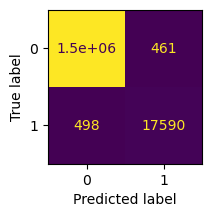

In [171]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_vis, y_pred_vis, ax=ax, colorbar=False)

## Visualize Map

In [172]:
df_pred = df_visualize[["zone_id", "ts", "country", "target"]].copy()
df_pred["proba"] = vis_proba
df_pred["log_proba"] = np.log(vis_proba)
df_pred["classified"] = np.where(vis_proba > 0.5, 1, 0)

In [173]:
df_pred_vis = df_pred.groupby(["country", "ts", "zone_id"]).max().reset_index().copy()
df_pred_vis["ts_month"] = df_pred_vis["ts"].dt.month
df_pred_vis.head()

,country,ts,zone_id,target,proba,log_proba,classified,ts_month
0,africa,2023-05-22,126,0,0.010632,-4.543874,0,5
1,africa,2023-05-22,135,1,0.992367,-0.007662,1,5
2,africa,2023-05-22,169,0,0.008752,-4.738474,0,5
3,africa,2023-05-22,178,1,0.787558,-0.238818,1,5
4,africa,2023-05-22,188,1,0.883838,-0.123481,1,5


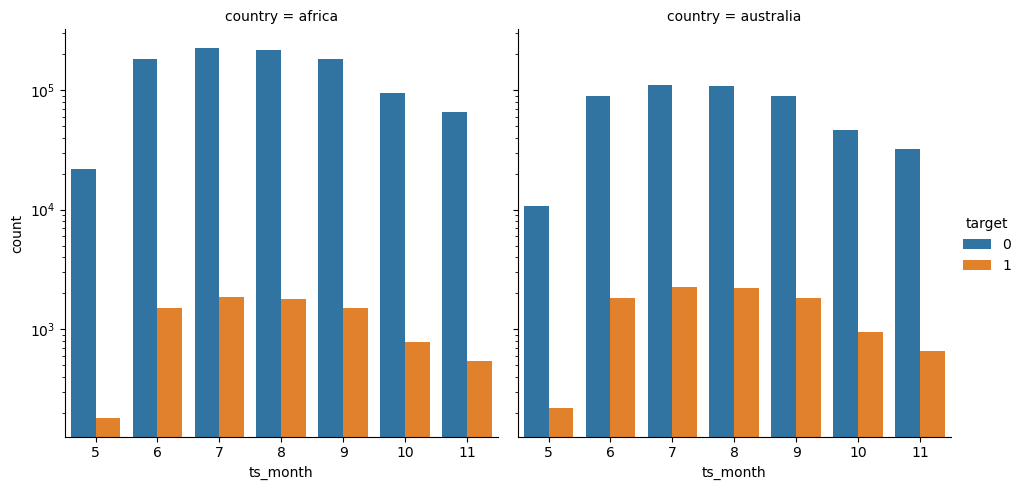

In [174]:
ddd = df_pred_vis[["country", "ts_month", "target"]].value_counts().sort_index().reset_index()
sns.catplot(kind="bar", data=ddd, x="ts_month", y="count", hue="target", col="country")
plt.yscale("log")

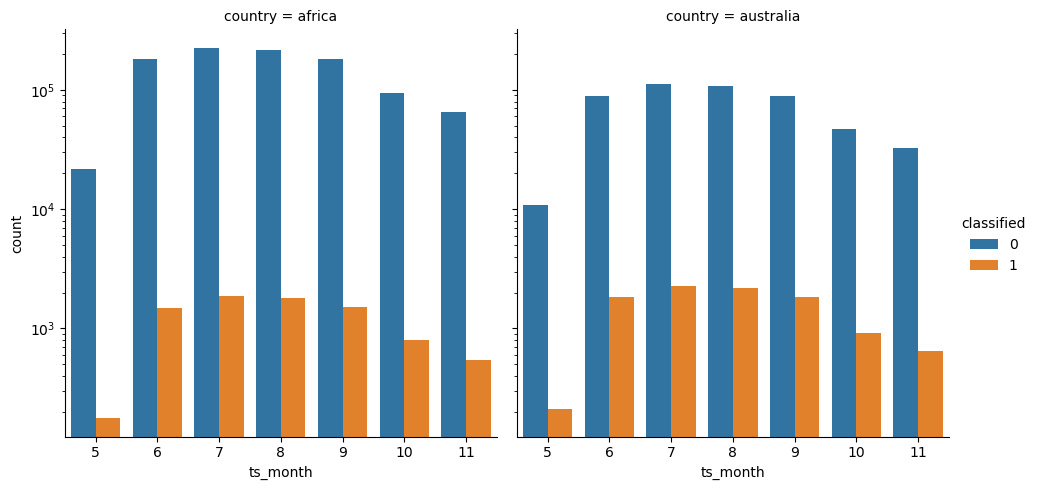

In [175]:
ddd = df_pred_vis[["country", "ts_month", "classified"]].value_counts().sort_index().reset_index()
sns.catplot(kind="bar", data=ddd, x="ts_month", y="count", hue="classified", col="country")
plt.yscale("log")

In [178]:
def f_mcc(x):
    TP = x[1, 1]
    TN = x[0, 0]
    FP = x[0, 1]
    FN = x[1, 0]
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return np.round(mcc, 4)

def f_f1(x):
    TP = x[1, 1]
    TN = x[0, 0]
    FP = x[0, 1]
    FN = x[1, 0]
    f1 = 2 * TP / (2 * TP + FP + FN)
    return np.round(f1, 4)

In [179]:
summary_whalemap = df_pred_vis.pivot_table(index=["country", "ts_month"], columns=["target", "classified"], aggfunc="size", fill_value=0)
summary_whalemap = summary_whalemap.reset_index()
summary_whalemap["mcc"] = summary_whalemap.apply(f_mcc, axis=1)
summary_whalemap["f1"] = summary_whalemap.apply(f_f1, axis=1)
summary_whalemap

target        country ts_month       0       1           mcc      f1
classified                           0   1   0     1                
0              africa        5   21857   4   7   173  0.9690  0.9692
1              africa        6  182163  12  18  1482  0.9899  0.9900
2              africa        7  225879  18   6  1854  0.9935  0.9936
3              africa        8  218594  16  14  1786  0.9916  0.9917
4              africa        9  182170   5   6  1494  0.9963  0.9963
5              africa       10   94711  20   7   773  0.9827  0.9828
6              africa       11   65568  15  14   526  0.9730  0.9732
7           australia        5   10761  15  23   196  0.9100  0.9116
8           australia        6   89730  70  50  1775  0.9666  0.9673
9           australia        7  111275  77  86  2177  0.9632  0.9639
10          australia        8  107716  44  59  2131  0.9759  0.9764
11          australia        9   89736  64  67  1758  0.9634  0.9641
12          australia       10   46652  44  75   874  0.9351  0.9363
13          australia       11   32271  57  66   591  0.9039  0.9057

In [74]:
def plot_map(df):
    fig, axes = plt.subplots(1, 2)
    axes[0].set_ylabel("Latitude")
    axes[0].set_xlabel("Longitude")
    df.plot(column="target", ax=axes[0])

    axes[1].set_ylabel("Latitude")
    axes[1].set_xlabel("Longitude")
    df.plot(column="classified", ax=axes[1])

    fig.tight_layout()
    plt.show()

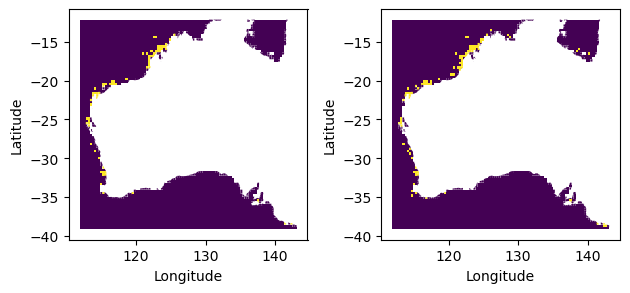

In [75]:
df_corr_aus = df_pred_vis[df_pred_vis["country"] == "australia"].copy()
gpd_res_aus = gpd_australia.merge(df_corr_aus, left_on="ZONE_ID", right_on="zone_id", how="left").drop(columns=["country", "zone_id"])
# gpd_res_aus.to_file("../dataset/reclassify/australia_classif_2023.shp")

plot_map(gpd_res_aus)
# gpd_res_aus.plot(column="classified")

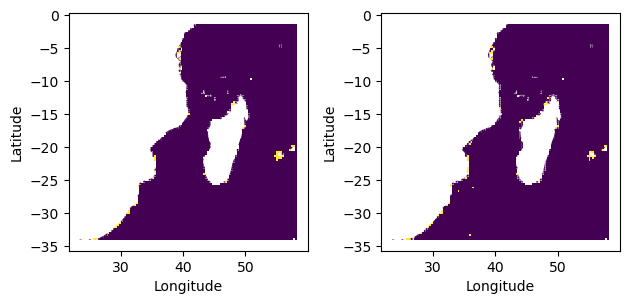

In [76]:
df_corr_africa = df_pred_vis[df_pred_vis["country"] == "africa"].copy()
gpd_res_africa = gpd_africa.merge(df_corr_africa, left_on="ZONE_ID", right_on="zone_id", how="left").drop(columns=["country", "zone_id"])
# gpd_res_africa.to_file("../dataset/reclassify/africa_classif_2023.shp")

plot_map(gpd_res_africa)
# gpd_res_africa.plot(column="classified")

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
# gpd_res_aus.plot(column="proba", ax=ax, legend=True, cax=cax)
gpd_res_africa.plot(column="proba", ax=ax, legend=True, cax=cax)


fig.tight_layout()
plt.show()

## TensorBoard Data

In [3]:
import os
import glob

from tbparse import SummaryReader

In [4]:
metrics_cols = ["name", "step", "epoch_loss", "epoch_accuracy", "epoch_precision", "epoch_recall", "epoch_auc", "epoch_prc", "epoch_tn", "epoch_tp", "epoch_fn", "epoch_fp"]
df_all = []

for log_dir in glob.glob("../scripts/logsr2/fit/**/*"):
    if not os.path.isdir(log_dir):
        continue

    print("Processing:", log_dir)
    reader = SummaryReader(log_dir, pivot=True)

    name = "_".join(log_dir.split("/")[-2:])
    df_summary = reader.tensors.copy().assign(name=name)
    
    df_all.append(df_summary[metrics_cols].iloc[1:, :].dropna())

df_all = pd.concat(df_all, ignore_index=True)
df_all

Processing: ../scripts/logsr2/fit/model-all_resnet_focal/validation
Processing: ../scripts/logsr2/fit/model-all_resnet_focal/train
Processing: ../scripts/logsr2/fit/model-all_fcn_focal/validation
Processing: ../scripts/logsr2/fit/model-all_fcn_focal/train
Processing: ../scripts/logsr2/fit/model-sel-10_fcn_focal/validation
Processing: ../scripts/logsr2/fit/model-sel-10_fcn_focal/train
Processing: ../scripts/logsr2/fit/model-all_fcn_ctrossentropy/validation
Processing: ../scripts/logsr2/fit/model-all_fcn_ctrossentropy/train
Processing: ../scripts/logsr2/fit/model-sel-10_fcn_ctrossentropy/validation
Processing: ../scripts/logsr2/fit/model-sel-10_fcn_ctrossentropy/train
Processing: ../scripts/logsr2/fit/model-sel-10_resnet_focal/validation
Processing: ../scripts/logsr2/fit/model-sel-10_resnet_focal/train
Processing: ../scripts/logsr2/fit/model-all_resnet_ctrossentropy/validation
Processing: ../scripts/logsr2/fit/model-all_resnet_ctrossentropy/train
Processing: ../scripts/logsr2/fit/model-s

,name,step,epoch_loss,epoch_accuracy,epoch_precision,epoch_recall,epoch_auc,epoch_prc,epoch_tn,epoch_tp,epoch_fn,epoch_fp
0,model-all_resnet_focal_validation,1,0.003583,0.994428,0.758421,0.790411,0.997572,0.868407,311267.0,3017.0,800.0,961.0
1,model-all_resnet_focal_validation,2,0.002957,0.995276,0.807896,0.798795,0.998293,0.902541,311503.0,3049.0,768.0,725.0
2,model-all_resnet_focal_validation,3,0.002259,0.996529,0.879464,0.825779,0.998936,0.940274,311796.0,3152.0,665.0,432.0
3,model-all_resnet_focal_validation,4,0.002286,0.996738,0.902369,0.818444,0.998889,0.940681,311890.0,3124.0,693.0,338.0
4,model-all_resnet_focal_validation,5,0.002534,0.996241,0.852130,0.833377,0.998755,0.932488,311676.0,3181.0,636.0,552.0
...,...,...,...,...,...,...,...,...,...,...,...,...
905,model-sel-10_resnet_ctrossentropy_train,77,0.001045,0.998449,0.942860,0.927792,0.999742,0.985549,2496101.0,28332.0,2205.0,1717.0
906,model-sel-10_resnet_ctrossentropy_train,78,0.001045,0.998444,0.943164,0.927072,0.999794,0.985538,2496112.0,28310.0,2227.0,1706.0
907,model-sel-10_resnet_ctrossentropy_train,79,0.001038,0.998443,0.944164,0.925860,0.999790,0.985725,2496146.0,28273.0,2264.0,1672.0
908,model-sel-10_resnet_ctrossentropy_train,80,0.001010,0.998503,0.945512,0.929659,0.999809,0.986496,2496182.0,28389.0,2148.0,1636.0


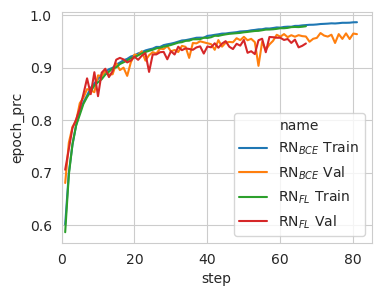

In [5]:
df_plot = df_all[df_all["name"].str.contains("10_resnet")].copy()
df_plot["name"] = df_plot["name"] \
    .str.replace("model-sel-10_", "") \
    .str.replace("model-all_", "") \
    .str.replace("ctrossentropy", "$_{BCE}$") \
    .str.replace("focal", "$_{FL}$") \
    .str.replace("fcn_", "FCN") \
    .str.replace("resnet_", "RN") \
    .str.replace("_validation", " Val") \
    .str.replace("_train", " Train")
df_plot = df_plot.sort_values(by="name", ascending=True)

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(4, 3))
    sns.lineplot(df_plot, x="step", y="epoch_prc", hue="name", legend="brief")
    plt.xlim(0)